# Recreation of "Using LSTM in Stock prediction and Quantitative Trading"
By Malcolm James Rutledge Skinner 11-13-2023

## Introduction
Major advancements in the analysis of financial data have recently occured, primarily in the context of large language models.  I explore whether those advancements can be applied with success to quantitative stock trading, leaning heavily on a paper published to ArXiv by Zhichao Zou and Zihao Qu (2020).  They achieved impressive results applying Attention Long-Short-Term-Memory models to data from 2004 to 2013, and using a simple long-short strategy. I explore a set of data from 2016 to 2023, to see if these results can be achieved today, demonstrate how to collect data, and how an interested person can find the best model available and optimize it.  I rely only on publicly available information, so if the reader has enough time, they can recreate this paper without any financial cost (although time may be a concern).

In [25]:
pip install bs4 selenium yfinance pandas webdriver_manager tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# This will help collect the CIKs, which are used to interact with the SEC's API.
import requests
from bs4 import BeautifulSoup

def fetch_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    table = soup.find('table', {'id': 'constituents'})
    tickers = [row.find_all('td')[0].text.strip() for row in table.find_all('tr')[1:]]
    return tickers

def download_ticker_cik_mapping():
    url = "https://www.sec.gov/include/ticker.txt"
    response = requests.get(url)
    ticker_cik_mapping = {line.split('\t')[0]: line.split('\t')[1] for line in response.text.splitlines()}
    return ticker_cik_mapping

def format_cik(cik):
    return str(cik).zfill(10)  # Pad the CIK to ensure it is 10 digits long

def map_sp500_tickers_to_cik():
    sp500_tickers = fetch_sp500_tickers()
    ticker_cik_mapping = download_ticker_cik_mapping()

    sp500_ticker_cik_mapping = {}
    for ticker in sp500_tickers:
        cik = ticker_cik_mapping.get(ticker.lower())
        if cik:
            formatted_cik = format_cik(cik)
            sp500_ticker_cik_mapping[ticker] = formatted_cik

    return sp500_ticker_cik_mapping
# Fetch and print the data
sp500_ticker_cik_mapping = map_sp500_tickers_to_cik()

In [3]:
import requests

def fetch_company_xbrl_facts(cik):
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    headers = {'User-Agent': 'ADVANCE INDUSTRIES LLC: MR. MALCOLM JAMES RUTLEDGE SKINNER'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for CIK {cik}. Status code: {response.status_code}")
        return None

def get_historical_data(data, concept_tags):
    historical_values = {}
    
    for tag in concept_tags:
        if tag in data['facts']['us-gaap']:
            tag_data = data['facts']['us-gaap'][tag]
            for unit in tag_data['units']:
                dates_seen = set()
                try:
                    # Reverse the list to start with the most recent entry
                    for item in reversed(tag_data['units'][unit]):
                        date = item.get('end', item.get('instant'))
                        if date not in dates_seen:
                            historical_values[(tag, unit, date)] = item['val']
                            dates_seen.add(date)
                except KeyError as e:
                    print(f"KeyError for tag {tag} under unit {unit}: {e}")

    # Convert the dictionary to a list of tuples for output
    return [(tag, unit, date, value) for (tag, unit, date), value in historical_values.items()]

def fetch_financial_historicals(cik):
    xbrl_data = fetch_company_xbrl_facts(cik)
    if xbrl_data:
        concepts = {
            'TotalLiabilities': [
                'Liabilities'
            ],
            'ShareholdersEquity': [
                'StockholdersEquity'
            ],
            'NetIncome': [
                'NetIncomeLoss'
            ],
            'Revenue': [
                'RevenueFromContractWithCustomerExcludingAssessedTax'
            ],
            'EarningsPerShareDiluted': [
                'EarningsPerShareBasic'
            ],
            'WeightedAverageNumberOfDilutedSharesOutstanding': [
                'CommonStockSharesOutstanding'
            ],
            'Assets':[
                'Assets'
            ]
        }
        historicals = {}
        for concept_name, concept_tags in concepts.items():
            historicals[concept_name] = get_historical_data(xbrl_data, concept_tags)
        return historicals
# Example usage for a specific company
cik = '0000789019'  # Example: CIK for Microsoft
financial_historicals = fetch_financial_historicals(cik)

{'TotalLiabilities': [('Liabilities', 'USD', '2023-09-30', 225071000000), ('Liabilities', 'USD', '2023-06-30', 205753000000), ('Liabilities', 'USD', '2023-03-31', 185405000000), ('Liabilities', 'USD', '2022-12-31', 181416000000), ('Liabilities', 'USD', '2022-09-30', 186218000000), ('Liabilities', 'USD', '2022-06-30', 198298000000), ('Liabilities', 'USD', '2022-03-31', 181683000000), ('Liabilities', 'USD', '2021-12-31', 180379000000), ('Liabilities', 'USD', '2021-09-30', 183440000000), ('Liabilities', 'USD', '2021-06-30', 191791000000), ('Liabilities', 'USD', '2021-03-31', 174374000000), ('Liabilities', 'USD', '2020-12-31', 173901000000), ('Liabilities', 'USD', '2020-09-30', 177609000000), ('Liabilities', 'USD', '2020-06-30', 183007000000), ('Liabilities', 'USD', '2020-03-31', 170948000000), ('Liabilities', 'USD', '2019-12-31', 172685000000), ('Liabilities', 'USD', '2019-09-30', 172894000000), ('Liabilities', 'USD', '2019-06-30', 184226000000), ('Liabilities', 'USD', '2019-03-31', 16841

In [4]:
import pandas as pd

def convert_to_dataframe(financial_historicals):
    # Initialize an empty dictionary to store restructured data
    data_restructured = {}
    
    # Loop over the historical data to populate the dictionary
    for key, values in financial_historicals.items():
        for value in values:
            date = value[2]
            if date not in data_restructured:
                data_restructured[date] = {}
            data_restructured[date][key] = value[3]
    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(data_restructured, orient='index')
    
    # Reset index to make the date a column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)
    
    # Reorder columns to match the desired output
    column_order = ['Date', 'TotalLiabilities', 'ShareholdersEquity', 'NetIncome', 
                    'Revenue', 'EarningsPerShareDiluted', 
                    'WeightedAverageNumberOfDilutedSharesOutstanding', 'Assets']
    df = df[column_order]
    
    # Sort by date in descending order to get the most recent first
    df.sort_values(by='Date', ascending=False, inplace=True)
    
    # Drop rows with any NA values that occur after the last complete row
    df = df.dropna().reset_index(drop=True)
    
    return df

# Example usage of the function
# financial_historicals would be the output from your previous code
financial_df = convert_to_dataframe(financial_historicals)

In [5]:
# This returns all of the XBRL tags and the date ranges that are used.
# This code will be essential for feature engineering.  Essentially, all of the fundamental variables can be collected, and the most useful can be found with good data mining strategies.
import requests

def fetch_company_xbrl_tags(cik):
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    headers = {'User-Agent': 'Your User Agent Info'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for CIK {cik}. Status code: {response.status_code}")
        return None

def extract_xbrl_tags_with_dates(xbrl_data):
    tag_dates = {}
    if xbrl_data and 'facts' in xbrl_data and 'us-gaap' in xbrl_data['facts']:
        for tag, data in xbrl_data['facts']['us-gaap'].items():
            dates = []
            for unit in data['units'].values():
                for item in unit:
                    date = item.get('end', item.get('instant'))
                    if date:
                        dates.append(date)
            if dates:
                tag_dates[tag] = (min(dates), max(dates))
    return tag_dates

cik = '0000789019'  # Example: CIK for Microsoft
xbrl_data = fetch_company_xbrl_tags(cik)

if xbrl_data:
    xbrl_tags_dates = extract_xbrl_tags_with_dates(xbrl_data)
    for tag, dates in sorted(xbrl_tags_dates.items()):
        print(f"Tag: {tag}, Date Range: {dates[0]} to {dates[1]}")
else:
    print("No XBRL data found.")

Tag: AccountsPayableCurrent, Date Range: 2009-06-30 to 2023-09-30
Tag: AccountsReceivableNet, Date Range: 2016-07-01 to 2016-07-01
Tag: AccountsReceivableNetCurrent, Date Range: 2009-06-30 to 2023-09-30
Tag: AccountsReceivableNetNoncurrent, Date Range: 2017-06-30 to 2023-09-30
Tag: AccruedIncomeTaxesCurrent, Date Range: 2009-06-30 to 2023-09-30
Tag: AccruedIncomeTaxesNoncurrent, Date Range: 2010-06-30 to 2023-09-30
Tag: AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, Date Range: 2009-06-30 to 2023-09-30
Tag: AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax, Date Range: 2008-06-30 to 2013-06-30
Tag: AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax, Date Range: 2008-06-30 to 2013-06-30
Tag: AccumulatedOtherComprehensiveIncomeLossForeignCurrencyTranslationAdjustmentNetOfTax, Date Range: 2008-06-30 to 2013-06-30
Tag: AccumulatedOtherComprehensiveIncomeLossNetOfTax, Date Range: 

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

def get_splits_with_selenium(ticker):
    options = webdriver.ChromeOptions()
    options.headless = True
    service = Service(ChromeDriverManager().install())
    browser = webdriver.Chrome(service=service, options=options)

    url = f'https://seekingalpha.com/symbol/{ticker}/splits'
    browser.get(url)
    browser.implicitly_wait(10)

    # Scroll the page to ensure all elements are loaded
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)  # Wait for the page to load

    soup = BeautifulSoup(browser.page_source, 'html.parser')
    splits_table = soup.find('tbody', {'data-test-id': 'table-body'})
    splits = []
    
    if splits_table:
        for row in splits_table.find_all('tr'):
            date = row.find('th').get_text(strip=True)
            ratio = row.find('td').get_text(strip=True)
            splits.append({'date': date, 'ratio': ratio})

    browser.quit()
    return splits

import pandas as pd

def get_splits_dataframe(ticker):
    splits_data = get_splits_with_selenium(ticker)
    # Convert the list of dictionaries to a DataFrame
    splits_df = pd.DataFrame(splits_data)
    
    # Check if the DataFrame is empty or not
    if not splits_df.empty:
        # Convert the 'date' column to datetime format, infer the datetime format automatically
        splits_df['date'] = pd.to_datetime(splits_df['date'], errors='coerce')
        
        # Handle the 'ratio' column, convert '3:1' to 3.0, for example
        def convert_ratio(ratio):
            try:
                return float(ratio.split(':')[0].strip()) / float(ratio.split(':')[1].strip())
            except (ValueError, IndexError):
                return pd.NA  # Use pandas NA for missing or malformed data

        splits_df['ratio'] = splits_df['ratio'].apply(convert_ratio)
        
        # Drop rows with NA values in 'date' or 'ratio' column
        splits_df.dropna(subset=['date', 'ratio'], inplace=True)
        
        # Sort by date in descending order to get the most recent first
        splits_df.sort_values(by='date', ascending=False, inplace=True)
        
        # Drop rows below the most recent 'NA' in the DataFrame
        idx_most_recent_na = splits_df[splits_df.isna().any(axis=1)].index.max()
        if pd.notna(idx_most_recent_na):
            splits_df = splits_df.loc[:idx_most_recent_na]
        
    return splits_df

# Example usage with ticker "MSFT"
splits_df = get_splits_dataframe("MSFT")

        date  ratio
0 2003-02-18    2.0
1 1999-03-29    2.0
2 1998-02-23    2.0
3 1996-12-09    2.0
5 1992-06-15    1.5
6 1991-06-27    1.5
7 1990-04-16    2.0
8 1987-09-21    2.0


In [7]:
def adjust_eps_for_splits(financial_df, splits_df):
    # Ensure 'Date' columns in both dataframes are of type datetime
    financial_df['Date'] = pd.to_datetime(financial_df['Date'])
    splits_df['date'] = pd.to_datetime(splits_df['date'])
    
    # Sort splits_df by date in ascending order to process earlier splits first
    splits_df.sort_values('date', ascending=True, inplace=True)
    
    # Loop over each split and adjust EPS in financial_df accordingly
    for index, row in splits_df.iterrows():
        split_date = row['date']
        split_ratio = row['ratio']
        
        # Adjust the EPS for all financial entries before the split date
        mask = financial_df['Date'] < split_date
        financial_df.loc[mask, 'EarningsPerShareDiluted'] /= split_ratio
    
    return financial_df

# Assuming financial_df and splits_df are already defined and have the correct data
# Call the function with the dataframes
adjusted_financial_df = adjust_eps_for_splits(financial_df, splits_df)

         Date  TotalLiabilities  ShareholdersEquity     NetIncome  \
0  2023-09-30      2.250710e+11        2.207140e+11  2.229100e+10   
1  2023-06-30      2.057530e+11        2.062230e+11  7.236100e+10   
2  2023-03-31      1.854050e+11        1.946830e+11  1.829900e+10   
3  2022-12-31      1.814160e+11        1.831360e+11  1.642500e+10   
4  2022-09-30      1.862180e+11        1.735660e+11  1.755600e+10   
5  2022-06-30      1.982980e+11        1.665420e+11  7.273800e+10   
6  2022-03-31      1.816830e+11        1.629240e+11  1.672800e+10   
7  2021-12-31      1.803790e+11        1.600100e+11  1.876500e+10   
8  2021-09-30      1.834400e+11        1.519780e+11  2.050500e+10   
9  2021-06-30      1.917910e+11        1.419880e+11  6.127100e+10   
10 2021-03-31      1.743740e+11        1.345050e+11  1.545700e+10   
11 2020-12-31      1.739010e+11        1.302360e+11  1.546300e+10   
12 2020-09-30      1.776090e+11        1.233920e+11  1.389300e+10   
13 2020-06-30      1.830070e+11   

In [8]:
def calculate_and_trim_ttm(financial_df):
    # Ensure the DataFrame is sorted by date in ascending order
    financial_df.sort_values('Date', ascending=True, inplace=True)
    
    # Calculate the TTM sums for the relevant columns
    financial_df['RevenueTTM'] = financial_df['Revenue'].rolling(window=4, min_periods=4).sum()
    financial_df['EarningsPerShareTTM'] = financial_df['EarningsPerShareDiluted'].rolling(window=4, min_periods=4).sum()
    financial_df['NetIncomeTTM'] = financial_df['NetIncome'].rolling(window=4, min_periods=4).sum()
    
    # Drop the initial rows where TTM values are NaN
    financial_df.dropna(subset=['RevenueTTM', 'EarningsPerShareTTM', 'NetIncomeTTM'], inplace=True)
    
    # Remove non-TTM columns
    columns_to_keep = ['Date', 'TotalLiabilities', 'ShareholdersEquity', 'WeightedAverageNumberOfDilutedSharesOutstanding', 'Assets', 'RevenueTTM', 'EarningsPerShareTTM', 'NetIncomeTTM']
    financial_df = financial_df[columns_to_keep]
    
    # Reset index after dropping rows
    financial_df.reset_index(drop=True, inplace=True)
    
    return financial_df

# Example usage
ttm_financial_df = calculate_and_trim_ttm(financial_df)
print(ttm_financial_df.head())

        Date  TotalLiabilities  ShareholdersEquity  \
0 2017-03-31      1.552880e+11        8.349100e+10   
1 2017-06-30      1.626010e+11        8.771100e+10   
2 2017-09-30      1.594500e+11        8.964700e+10   
3 2017-12-31      1.776430e+11        7.836000e+10   
4 2018-03-31      1.662580e+11        7.923900e+10   

   WeightedAverageNumberOfDilutedSharesOutstanding        Assets  \
0                                     7.723000e+09  2.250170e+11   
1                                     7.708000e+09  2.503120e+11   
2                                     7.720000e+09  2.490970e+11   
3                                     7.705000e+09  2.560030e+11   
4                                     7.690000e+09  2.454970e+11   

     RevenueTTM  EarningsPerShareTTM  NetIncomeTTM  
0  1.621200e+11                 2.65  2.054200e+10  
1  9.657100e+10                 3.30  2.548900e+10  
2  9.918100e+10                 3.42  2.639800e+10  
3  1.022730e+11                 1.79  1.382900e+10  
4

In [9]:
import pandas as pd
import yfinance as yf

def download_and_merge_market_with_financials(ticker, financial_df):
    # Convert 'Date' column in financial_df to datetime if it's not already
    financial_df['Date'] = pd.to_datetime(financial_df['Date'])
    financial_df.set_index('Date', inplace=True)

    # Define start and end dates based on financial_df for the yfinance download
    start_date = financial_df.index.min().strftime('%Y-%m-%d')
    end_date = financial_df.index.max().strftime('%Y-%m-%d')

    # Download market data using yfinance
    market_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Reset index to ensure 'Date' is a column in market_data
    market_data.reset_index(inplace=True)
    market_data['Date'] = pd.to_datetime(market_data['Date'])
    market_data.set_index('Date', inplace=True)

    # Forward fill the financial data to align with the daily market data
    financial_filled = financial_df.asfreq('D').fillna(method='ffill')

    # Merge the market data with the forward-filled financial data
    full_data_df = financial_filled.join(market_data[['Adj Close', 'Volume']], how='outer')

    # Backfill any missing market data after the last financial date
    full_data_df.fillna(method='bfill', inplace=True)
    
    # Reset index to turn 'Date' back into a column
    full_data_df.reset_index(inplace=True)

    # Drop any rows that still contain NaN values after backfilling (if any)
    full_data_df.dropna(inplace=True)

    return full_data_df

full_data_df = download_and_merge_market_with_financials('MSFT', ttm_financial_df)

C:\Users\mjrsk\AppData\Local\Temp\ipykernel_11612\2641042945.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_df['Date'] = pd.to_datetime(financial_df['Date'])


        Date  TotalLiabilities  ShareholdersEquity  \
0 2017-03-31      1.552880e+11        8.349100e+10   
1 2017-04-01      1.552880e+11        8.349100e+10   
2 2017-04-02      1.552880e+11        8.349100e+10   
3 2017-04-03      1.552880e+11        8.349100e+10   
4 2017-04-04      1.552880e+11        8.349100e+10   

   WeightedAverageNumberOfDilutedSharesOutstanding        Assets  \
0                                     7.723000e+09  2.250170e+11   
1                                     7.723000e+09  2.250170e+11   
2                                     7.723000e+09  2.250170e+11   
3                                     7.723000e+09  2.250170e+11   
4                                     7.723000e+09  2.250170e+11   

     RevenueTTM  EarningsPerShareTTM  NetIncomeTTM  Adj Close      Volume  
0  1.621200e+11                 2.65  2.054200e+10  60.620892  21040300.0  
1  1.621200e+11                 2.65  2.054200e+10  60.335548  20400900.0  
2  1.621200e+11                 2.65  

In [10]:
# Get beta, if possible

In [11]:
import pandas as pd

def calculate_financial_ratios(full_data_df):
    # Calculate the financial ratios
    full_data_df['DE Ratio'] = full_data_df['TotalLiabilities'] / full_data_df['ShareholdersEquity']
    full_data_df['Return on Equity'] = full_data_df['NetIncomeTTM'] / full_data_df['ShareholdersEquity']
    full_data_df['Price/Book'] = full_data_df['Adj Close'] / (full_data_df['ShareholdersEquity'] / full_data_df['WeightedAverageNumberOfDilutedSharesOutstanding'])
    full_data_df['Profit Margin'] = full_data_df['NetIncomeTTM'] / full_data_df['RevenueTTM']
    full_data_df['Diluted EPS'] = full_data_df['EarningsPerShareTTM']
    # Assuming Beta is a constant as it's not part of the full_data_df, set it to 1 as a placeholder

    # Select only the required columns
    columns_to_select = ['Date', 'Adj Close', 'Volume', 'DE Ratio', 'Return on Equity', 'Price/Book', 'Profit Margin', 'Diluted EPS']
    ratios_df = full_data_df[columns_to_select]

    # Rename columns to match the requirement
    ratios_df.rename(columns={'Adj Close': 'adj_close', 'Volume': 'volume', 'DE Ratio': 'DE Ratio', 'Return on Equity': 'Return on Equity', 'Price/Book': 'Price/Book', 'Profit Margin': 'Profit Margin', 'Diluted EPS': 'Diluted EPS'}, inplace=True)
    
    # Ensure the date is in the correct format if needed
    ratios_df['Date'] = pd.to_datetime(ratios_df['Date']).dt.strftime('%Y-%m-%d')
    
    return ratios_df

# Use the function on your full_data_df
financial_ratios_df = calculate_financial_ratios(full_data_df)


         Date  adj_close      volume  DE Ratio  Return on Equity  Price/Book  \
0  2017-03-31  60.620892  21040300.0  1.859937          0.246038    5.607492   
1  2017-04-01  60.335548  20400900.0  1.859937          0.246038    5.581098   
2  2017-04-02  60.335548  20400900.0  1.859937          0.246038    5.581098   
3  2017-04-03  60.335548  20400900.0  1.859937          0.246038    5.581098   
4  2017-04-04  60.501221  12997400.0  1.859937          0.246038    5.596423   

   Profit Margin  Diluted EPS  
0       0.126709         2.65  
1       0.126709         2.65  
2       0.126709         2.65  
3       0.126709         2.65  
4       0.126709         2.65  


C:\Users\mjrsk\AppData\Local\Temp\ipykernel_11612\3652731402.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios_df.rename(columns={'Adj Close': 'adj_close', 'Volume': 'volume', 'DE Ratio': 'DE Ratio', 'Return on Equity': 'Return on Equity', 'Price/Book': 'Price/Book', 'Profit Margin': 'Profit Margin', 'Diluted EPS': 'Diluted EPS'}, inplace=True)
C:\Users\mjrsk\AppData\Local\Temp\ipykernel_11612\3652731402.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios_df['Date'] = pd.to_datetime(ratios_df['Date']).dt.strftime('%Y-%m-%d')


In [ ]:
# remove weekends and holidays.
import pandas as pd

def remove_non_trading_days(df):
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter out weekends
    df = df[df['Date'].dt.dayofweek < 5]

    return df

# Apply the function to your dataframe
cleaned_full_data_df = remove_non_trading_days(financial_ratios_df)
print(cleaned_full_data_df)

In [20]:
# log and generalized log transformation for EPS and adjusted close
import numpy as np
import pandas as pd

# Copy the original DataFrame
log_transformation_df = cleaned_full_data_df.copy()

# Generalized log transformation for 'Diluted EPS'
log_transformation_df['transformed_eps'] = np.log(log_transformation_df['Diluted EPS'] + np.sqrt(log_transformation_df['Diluted EPS']**2 + 1))

# Simple log transformation for 'adj_close'
log_transformation_df['log_adj_close'] = np.log(log_transformation_df['adj_close'])

# Handle any potential infinities or NaNs
log_transformation_df.replace([np.inf, -np.inf], np.nan, inplace=True)
log_transformation_df.dropna(inplace=True)


In [23]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Copy the log_transformation_df to a new DataFrame
analysis_ready_df = log_transformation_df.copy()

# Exclude 'Date' column from scaling
columns_to_scale = analysis_ready_df.columns.drop('Date')

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the columns except for 'Date'
analysis_ready_df[columns_to_scale] = scaler.fit_transform(analysis_ready_df[columns_to_scale])

# Create the target variable y - adjusted close price of the next day
# Shift the 'log_adj_close' column up by one
analysis_ready_df['y'] = analysis_ready_df['log_adj_close'].shift(-1)

# Drop the last row as it will not have a corresponding future value
analysis_ready_df = analysis_ready_df[:-1]


In [40]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df = analysis_ready_df.drop(columns=['Date'])

# Define features (X) and target (y)
X = df.drop(columns=['y']).values
y = df['y'].values

# Decide on the size of each set
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

# Split the data into training, validation, and testing sets in a way that respects the time sequence
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Reshape input to be [samples, time steps, features] for LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Continue with model definition and training...


# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
32/32 [==============================] - 2s 17ms/step - loss: 0.0715 - val_loss: 0.0222
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0042
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0114
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0113
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0111
Epoch 8/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 9/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0082
Epoch 10/20
32/32 [==============================] - 0s 3ms/step - loss: 8.4173e-04 - val_loss: 0.0074
Epoch 11/20
32

11/11 [==============================] - 0s 544us/step
Mean Squared Error: 0.00177627084983187
Mean Absolute Error: 0.035007636943648154
Root Mean Squared Error: 0.0421458283799461


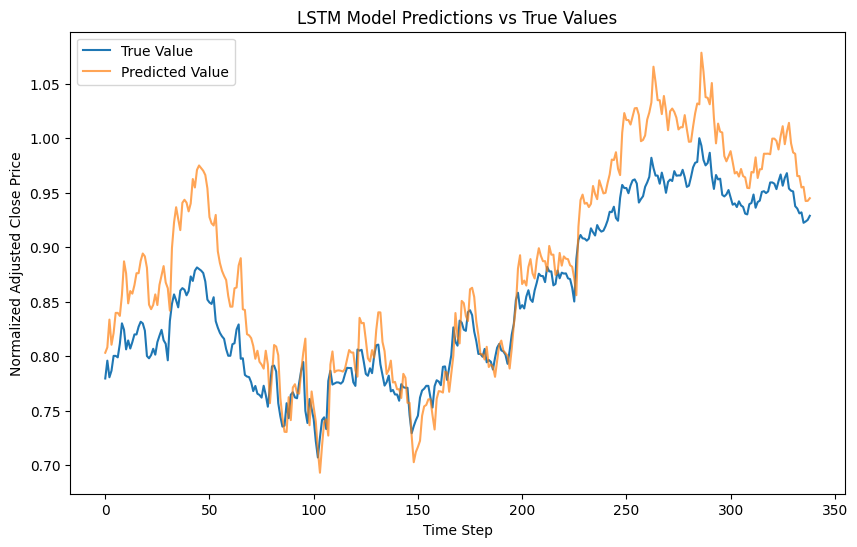

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='Predicted Value', alpha=0.7)
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Normalized Adjusted Close Price')
plt.legend()
plt.show()

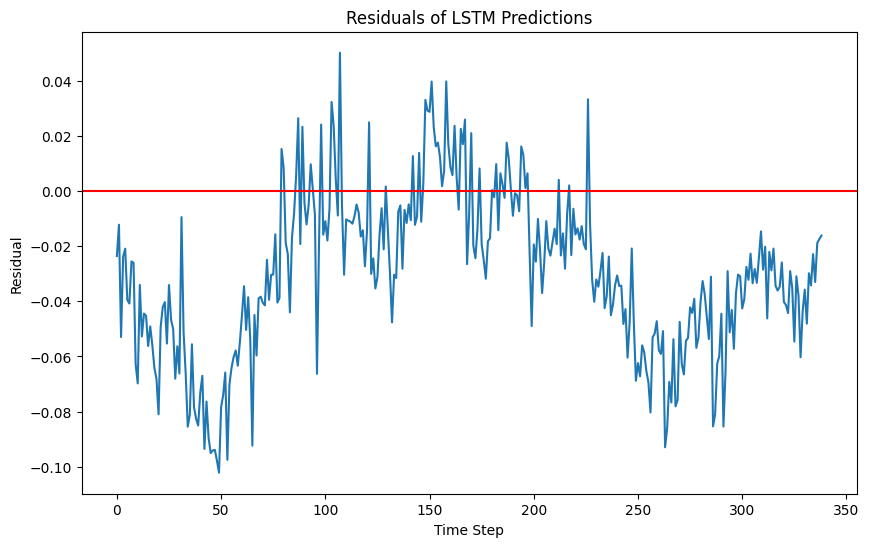

In [42]:
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of LSTM Predictions')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

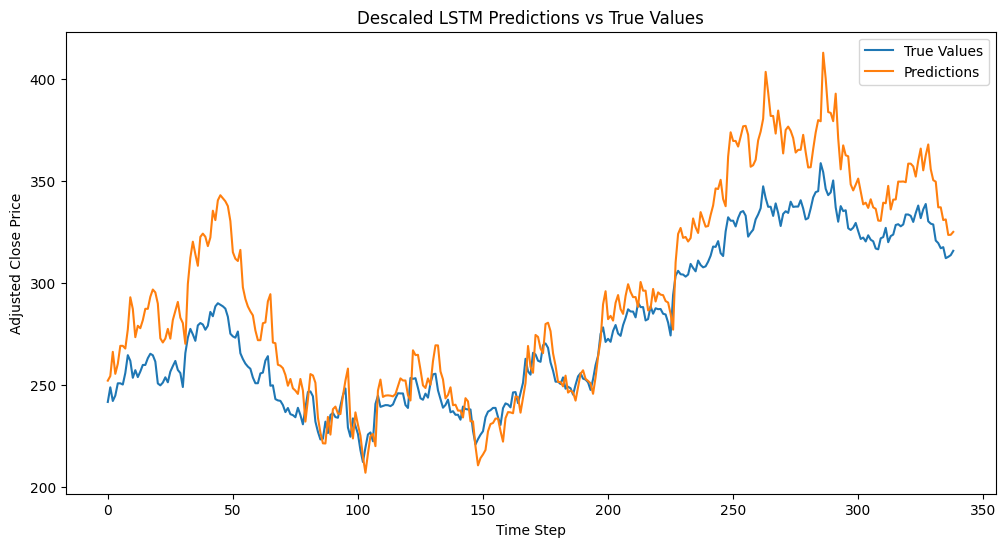

In [44]:
# Get the shape of the original scaled dataset
num_features = X_train.shape[2]  # Number of features used in the scaling

# Create a dummy array with the appropriate shape
dummy_array = np.zeros((len(y_pred), num_features))

# Insert the scaled 'log_adj_close' predictions into the last column of the dummy array
dummy_array[:, -1] = y_pred.flatten()

# Apply the inverse transformation to the dummy array
y_pred_descaled = scaler.inverse_transform(dummy_array)[:, -1]

# Apply the exponential function to reverse the log transformation on 'log_adj_close'
y_pred_final = np.exp(y_pred_descaled)

# Repeat the process for the true values
dummy_array[:, -1] = y_test.flatten()
y_test_descaled = scaler.inverse_transform(dummy_array)[:, -1]
y_test_final = np.exp(y_test_descaled)

# Plot the descaled predictions and true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='True Values')
plt.plot(y_pred_final, label='Predictions')
plt.title('Descaled LSTM Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


## Discussion

Use changes as y variable.  Figure out how to make normal distribution for EPS and price so that the machine learning algorithm has an easier time.  This is not bad, but it could be improved significantly.  Adding in the attention mechanism could be very helpful.  Remember, a lot of useful data isn't included, like Beta, sentiment, and other accounting statistics.  Cool result tbh.